In [ ]:
import keras
import pandas as pd
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pylab
from IPython.display import SVG
# from keras.utils.visualize_utils import model_to_dot


In [ ]:
import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable
from keras.datasets import fashion_mnist
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# from PIL import Image

# def extract_rgb(image_path):
#     # Open the image file
#     image = Image.open(image_path)

#     # Get the RGB values of each pixel
#     rgb_values = list(image.getdata())

#     return rgb_values

# def main():
#     # Replace 'path_to_your_folder' with the actual path to your pictures folder
#     folder_path = 'path_to_your_folder'

#     # List all files in the folder
#     import os
#     files = os.listdir(folder_path)

#     # Extract RGB values from each image
#     for file in files:
#         if file.endswith(('.jpg', '.jpeg', '.png')):  # You can add more extensions if needed
#             image_path = os.path.join(folder_path, file)
#             rgb_values = extract_rgb(image_path)
#             print(f"RGB values for {file}: {rgb_values}")

# if __name__ == "__main__":
#     main()


In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
use_gpu

True

Visualize the network architecture
We can actually visualize this network architecture using the following code snippet to understand the layers that have been used in this network, in a better way.

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.reshape(-1,1).shape

(60000, 1)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
y_test.reshape(-1,1).shape

(10000, 1)

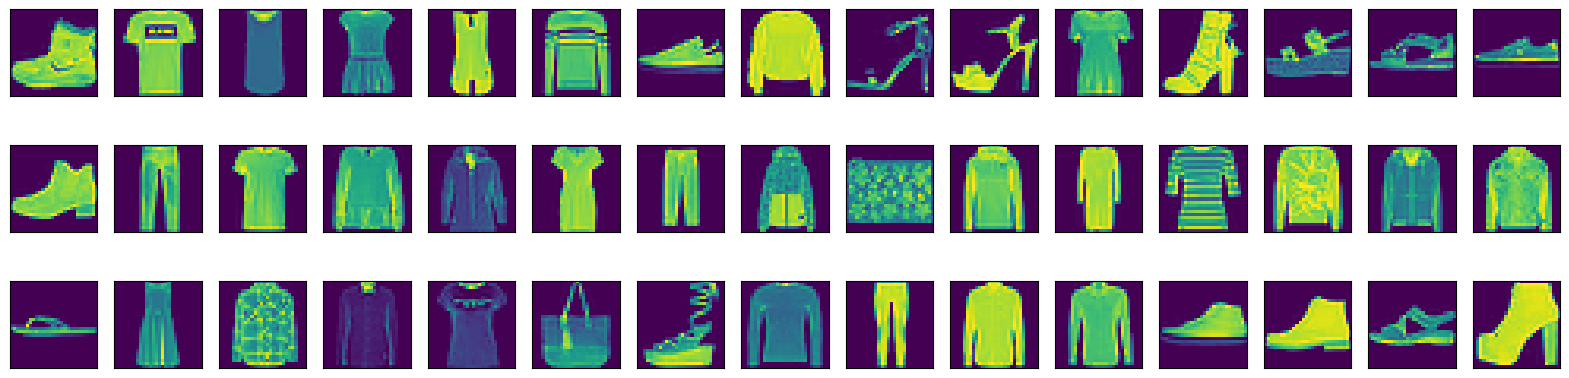

In [ ]:
fig = plt.figure(figsize=(20,5))

for i in range(45):
  ax = fig.add_subplot(3,15,i+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(x_train[i]))



In [ ]:
labels = np.unique(y_train)
print(len(labels))
for i in labels:
  print(i)

10
0
1
2
3
4
5
6
7
8
9


In [ ]:
# Step 1 : Scale the data
# from keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)


x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
# step 2 : train test validation data set

# one hot encoding
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train,num_classes)
y_test = keras.utils.to_categorical(y_test,num_classes)

In [ ]:
(x_val, x_train) = x_train[:5000], x_train[5000:]
(y_val, y_train) = y_train[:5000], y_train[5000:]

In [ ]:
print(x_train.shape)

print(f'training data samples {x_train.shape[0]}')
print(f'validation data samples {x_val.shape[0]}')
print(f'testing data samples {x_test.shape[0]}')


(55000, 28, 28)
training data samples 55000
validation data samples 5000
testing data samples 10000


In [ ]:
y_train.dtype

dtype('float32')

In [ ]:
# step 3 : convolution layers, pooling , model creation

In [ ]:
from keras.metrics import Mean
from sklearn.metrics import f1_score
import keras.backend as K
from keras.callbacks import Callback

In [ ]:
# Define the weighted F1 score callback
class WeightedF1ScoreCallback(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs={}):
        x_val, y_val = self.validation_data
        y_pred = np.argmax(self.model.predict(x_val), axis=-1)
        y_true = np.argmax(y_val, axis=-1)
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f'Weighted F1 Score: {f1}')
        logs['weighted_f1_score'] = f1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


In [ ]:
model = Sequential()
model.add(Conv2D(filters=16,kernel_size=3, padding='same', activation='relu',input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(250,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(250,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 64)         

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Create an instance of the callback
weighted_f1_callback = WeightedF1ScoreCallback(validation_data=(x_val, y_val))

In [ ]:
hist = model.fit(x_train,y_train, verbose=1,validation_data=(x_val,y_val), batch_size=32, epochs=30, shuffle=True, callbacks=[weighted_f1_callback])


Epoch 1/30
157/157 [==============================] - 0s 2ms/step
Weighted F1 Score: 0.8681613203836334
1719/1719 [==============================] - 15s 7ms/step - loss: 0.5724 - accuracy: 0.7851 - val_loss: 0.3482 - val_accuracy: 0.8746 - weighted_f1_score: 0.8682
Epoch 2/30
157/157 [==============================] - 1s 3ms/step
Weighted F1 Score: 0.8926506771002081
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3618 - accuracy: 0.8685 - val_loss: 0.2972 - val_accuracy: 0.8912 - weighted_f1_score: 0.8927
Epoch 3/30
157/157 [==============================] - 1s 4ms/step
Weighted F1 Score: 0.8980300217777795
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3163 - accuracy: 0.8842 - val_loss: 0.2591 - val_accuracy: 0.9008 - weighted_f1_score: 0.8980
Epoch 4/30
157/157 [==============================] - 0s 3ms/step
Weighted F1 Score: 0.9087779682539161
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2941 - accuracy: 0.8937 - val_

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'weighted_f1_score'])


In [ ]:
y_hat = model.predict(x_test)

fashion_label = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal',\
                 'Shirt','Sneaker','Bag','Ankle boot']

313/313 [==============================] - 1s 2ms/step


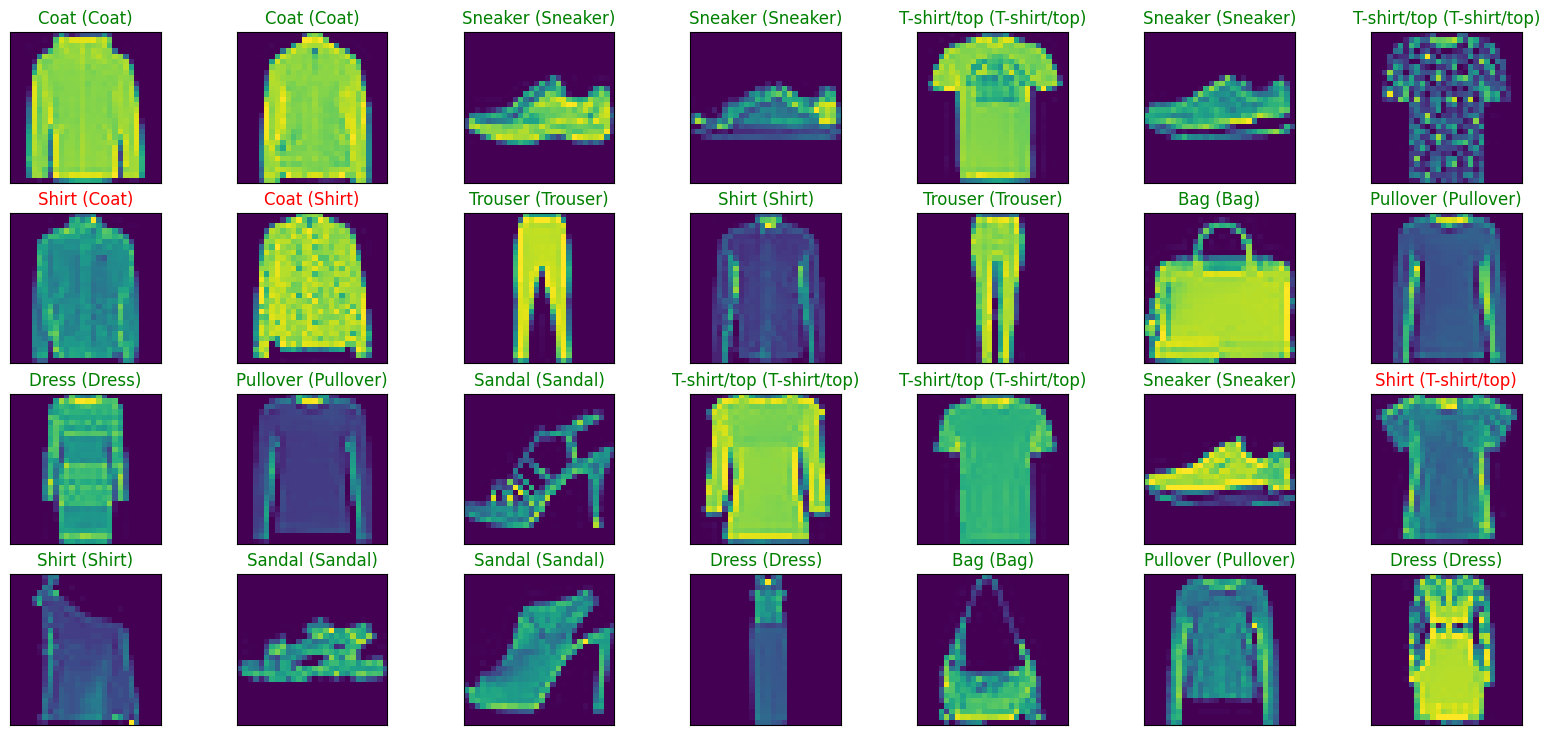

In [ ]:
fig = plt.figure(figsize=(20,9))
for i,idx in enumerate(np.random.choice(x_test.shape[0],size=28,replace=False)):
  ax = fig.add_subplot(4,7,i+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(x_test[idx]))
  predict_idx = np.argmax(y_hat[idx])
  true_idx = np.argmax(y_test[idx])
  ax.set_title("{} ({})".format(fashion_label[predict_idx],fashion_label[true_idx]),\
               color=("green" if predict_idx==true_idx else "red"))

In [ ]:
score = model.evaluate(x_test,y_test,verbose=1)

print(f'Test loss : {score[0]}')
print(f'Training score : {100*score[1]}%')

313/313 [==============================] - 1s 4ms/step - loss: 0.2521 - accuracy: 0.9131
Test loss : 0.252055823802948
Training score : 91.3100004196167%


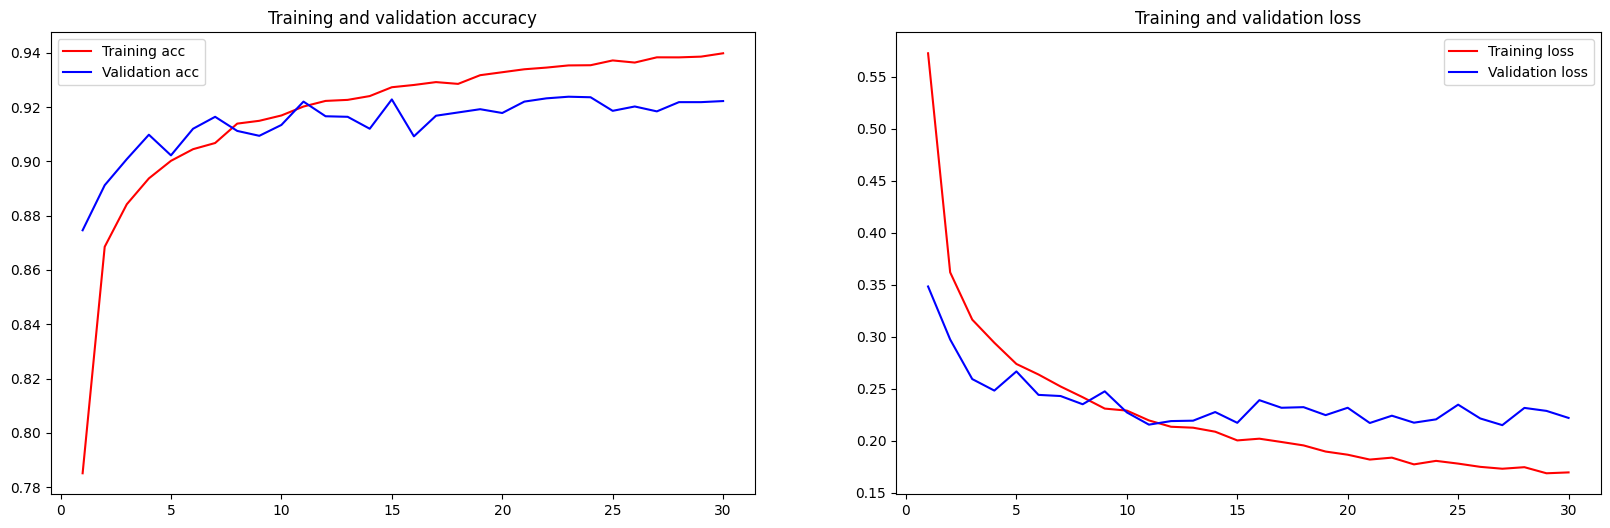

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save('fashion_mnist.keras')

In [ ]:
# SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))